In [ ]:
import requests
from bs4 import BeautifulSoup 
from datetime import datetime
import time 
import re

import numpy as np
import pandas as pd
from konlpy.tag import Okt
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

from PIL import Image 
from wordcloud import WordCloud, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # NanumGothic.otf
matplotlib.rc('font', family=font_name)

# 네이버뉴스 스크래핑

In [ ]:
max_page = 3 # 검색할 페이지의 수
current_call = 1  # start의 전달인자
last_call = (max_page - 1) * 10 + 1  # 크롤링할 마지막 페이지의 start값

query = '홈트레이닝'
search_year = ['18','19','20','21']
search_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


for year in search_year:  # 2018 ~ 2021
    # 1년 단위로 크롤링한 데이터를 저장할 리스트
    titles = []
    dates = []
    articles = []
    article_urls = []
    press_companies = []
    
    for month in search_month:  # 1월 ~ 12월
        
        while current_call <= last_call:
            print('\n20{}.{} {}번째 기사글부터 크롤링을 시작합니다.'.format(year,month,current_call))
            
            # 검색기간 조건에서 월말이 넘는 값이 입력되도 해당 달의 뉴스기사가 뜹니다
            url = 'https://search.naver.com/search.naver?where=news&query=' + query + \
            '&pd=3&ds='+ '20{}.{}.01'.format(year,month) + '&de=' + '20{}.{}.31'.format(year,month) + '&start=' + str(current_call)
            response = requests.get(url).content
            soup_response = BeautifulSoup(response,'html.parser')

            # 1) 네이버 뉴스만 추려내기
            urls_list = []
            for urls in soup_response.find_all('a',{'class','info'}):
                if urls.attrs['href'].startswith('https://news.naver.com/'):
                    urls_list.append(urls.attrs['href'])

            headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}
            error_urls=[]  # 에러난 사이트의 url을 담을 리스트
            for url in urls_list:
                try:
                    news = requests.get(url, headers=headers).content
                    soup_news = BeautifulSoup(news,'html.parser')

                    # 2) 기사 제목
                    title = soup_news.find('h3', {'id' : 'articleTitle'}).get_text()
                    print('Processing article : {}'.format(title))

                    # 3) 기사 날짜
                    date = soup_news.find('span', {'class' : 't11'}).get_text()

                    # 4) 기사 본문
                    article_content = soup_news.find('div', {'id' : 'articleBodyContents'}).get_text()
                    article_content = article_content.replace('\n','')
                    article_content = article_content.replace('◆','')
                    article_content = article_content.replace('▲','')
                    article_content = article_content.replace('// flash 오류를 우회하기 위한 함수 추가function _flash_removeCallback() {}','')
                    article_content = article_content.strip()
                    
                       # 이메일 이후로 삭제
                    print("\n원본 :",article_content)
                    pattern = re.compile(r'[\w.%+\-]+@[\w/-]+\.') 
                    email_address = pattern.search(article_content)
                    article_content = article_content[:email_address.start()]
                    print("\n이메일 이후 제거:",article_content)
                    
                      # [ ] < > ( ) 괄호로 감싸여 있는 부분 삭제
                    pattern = re.compile(r'[\[<(][\s\w,+\-./:=%]*[\]>)]')
                    article_content = pattern.sub('',article_content)
                    print("\n대괄호 제거후 : ",article_content)

                        
                    # 5) 기사 발행 언론사
                    press_company = soup_news.find('address', {'class' : 'address_cp'}).find('a').get_text()
                        
                    titles.append(title)
                    dates.append(date)
                    articles.append(article_content)
                    press_companies.append(press_company)
                    article_urls.append(url) # 6) 기사 URL 

                except:
                    print('*** 다음 링크의 뉴스를 크롤링 중 에러 발생 : {} ***'.format(url))
                    error_urls.append(url)

            time.sleep(5)
            current_call += 10  # 다음 페이지로 넘어간다
            
        current_call = 1  # start의 전달인자 초기화 (다시 1페이지부터 크롤링)   
        print('**************************20{}년 {}월 스크래핑 완료**************************'.format(year,month))
    
    # DataFrame으로 만든 후에 엑셀파일로 저장
    article_df = pd.DataFrame({'Title' : titles,
                  'Date' : dates,
                  'Article' : articles,
                  'URL' : article_urls,
                  'PressCompany' : press_companies})

    article_df.to_excel(r'C:\Users\user\Python_MLDL\Semi_Project_1\news_yearly_excelfile\{}news_20{}.xlsx'.format(query,year), index=False, encoding='utf-8')
    print('***********************{}news_20{}_{}.xlsx 파일생성 완료**********************'.format(query,year,month))

# 2018~2021 뉴스 텍스트 전처리

In [ ]:
# 연도별로 엑셀파일 불러오기
df_18 = pd.read_excel(r'C:\Users\user\Python_MLDL\Semi_Project_1\news_yearly_excelfile\홈트레이닝news_2018.xlsx')
df_19 = pd.read_excel(r'C:\Users\user\Python_MLDL\Semi_Project_1\news_yearly_excelfile\홈트레이닝news_2019.xlsx')
df_20 = pd.read_excel(r'C:\Users\user\Python_MLDL\Semi_Project_1\news_yearly_excelfile\홈트레이닝news_2020.xlsx')
df_21 = pd.read_excel(r'C:\Users\user\Python_MLDL\Semi_Project_1\news_yearly_excelfile\홈트레이닝news_2021.xlsx')

In [ ]:
articles_18 = df_18['Article'].tolist()
articles_19 = df_19['Article'].tolist()
articles_20 = df_20['Article'].tolist()
articles_21 = df_21['Article'].tolist()

In [ ]:
articles_18

In [ ]:
# 기사별 본문을 하나로 합쳐준다
articles_18 = ' '.join(articles_18)
articles_19 = ' '.join(articles_19)
articles_20 = ' '.join(articles_20)
articles_21 = ' '.join(articles_21)

In [ ]:
articles_20

' 최근 집에서 여가를 즐기는 이른바 ‘홈족’이 증가하면서 이와 함께 집에서 운동을 즐기는 ‘홈트족이 늘어나고 있다.내가 하고 싶은 시간에 집에서 운동을 하는 홈트족이 늘면서 운동을 하는 공간이 자연스럽게 헬스장이 아닌 집으로 변화된 것.이런 트렌드에 발맞춰 국내 최대 헬스케어 그룹 쥬비스 다이어트(이하 ‘쥬비스’)가 2020년 새로운 홈다이어트 브랜드인 ‘쥬비스 앳홈’을 런칭할 계획이라고 밝히며 사업을 함께 할 방문 운동 컨설턴트 모집을 위해 오는 2월 11일 대규모 사업 설명회를 개최할 예정이라고 전했다.새롭게 런칭하는 ‘쥬비스 앳홈’은 고객의 라이프 스타일과 니즈에 맞춰 고객이 원하는 시간에 방문 운동 컨설턴트가 고객의 집으로 방문해 쥬비스의 차별화된 다이어트 프로그램을 제공하는 서비스로 18년 쥬비스의 고객관리 경험과 기술력이 응집된 신개념 홈다이어트 서비스인 것으로 알려졌다.쥬비스 앳홈은 운동 트레이너가 직접 고객의 집으로 방문해 쥬비스의 전문성과 기술력이 응집된 감량 특화 기기로 내 몸 분석부터 관리가 한번에 가능한 것이 특징으로 영양소 분석과, 안티스트레스 분석, 인바디 분석 등 3가지 측정 시스템을 통해 전반적인 몸 상태를 분석하고 4가지 모드의 저주파 관리가 가능한 것으로 알려졌다.또한 AI가 분석한 근육 활성화, 영양소 분석, 행동 패턴 변화 수치 등 나의 감량 지표를 APP을 통해 한 눈에 볼 수 있다는 것 또한 쥬비스 앳홈의 차별화된 강점이라고 전했다.쥬비스는 해당 서비스 런칭을 위해 헬스트레이너, 요가, 필라테스 등 운동 전문가들을 대상으로 한 방문 운동 컨설턴트 모집을 위해 대규모 사업설명회를 진행할 예정이라고 밝히며 쥬비스 앳홈의 방문 운동 컨설턴트에게는 지금까지 경험하지 못한 동종업계 최고의 대우를 약속할 것이라고 전했다.쥬비스 관계자는 “쥬비스 앳홈 방문 컨설턴트가 되면 일 3명의 고객 관리를 기준으로 월 400만원 이상의 고수익이 가능한 시스템을 제공해 업계 최고의 대우를 받을 수 있도록 제공할 예정이다. 또한 16만명에 달하는

In [ ]:
tokenizer = Okt()
# 토큰화, 품사태깅
pos_tagged_18 = tokenizer.pos(articles_18, norm=True, stem=True)
pos_tagged_19 = tokenizer.pos(articles_19, norm=True, stem=True)
pos_tagged_20 = tokenizer.pos(articles_20, norm=True, stem=True)
pos_tagged_21 = tokenizer.pos(articles_21, norm=True, stem=True)

In [ ]:
pos_tagged_21

In [ ]:
# 불용어 제거 사용자 함수
def cleanWord(pos_tagged):
    del_list = ['하다', '있다', '되다', '이다', '돼다', '않다', 
            '그렇다', '아니다', '이렇다', '그렇다', '어떻다',
            '으로', '에서', '하고', '보다', '관련', '따르다',
            '오다', '통해', '가다', '기자', '에는', '같다',
            '이라고', '까지']
    word_cleaned = []
    for word, tag in pos_tagged:
        if tag not in ["josa", "Eomi", "Punctuation", "Foreign", "Suffix", "Alpha", "Determiner"]:
            if (len(word) != 1) & (word not in del_list):
                word_cleaned.append(word)
    
    return word_cleaned

In [ ]:
# 불용어를 제거한 텍스트를 저장할 리스트
word_cleaned_18 = []
word_cleaned_19 = []
word_cleaned_20 = []
word_cleaned_21 = []

# 불용어 제거
word_cleaned_18 = cleanWord(pos_tagged_18)
word_cleaned_19 = cleanWord(pos_tagged_19)
word_cleaned_20 = cleanWord(pos_tagged_20)
word_cleaned_21 = cleanWord(pos_tagged_21)

In [ ]:
word_cleaned_21

['김동현',
 '푸드',
 '프리미엄',
 '샐러드',
 '카페',
 '크리스',
 '프레',
 '호점',
 '서울',
 '용산',
 '아이파크몰',
 '28일',
 '신규',
 '오픈',
 '크리스',
 '프레',
 '그룹',
 '계열',
 '사가',
 '직접',
 '생산',
 '품질',
 '관리',
 '재료',
 '만들다',
 '프리미엄',
 '샐러드',
 '전문',
 '취급',
 '카페',
 '브랜드',
 '그룹',
 '농업',
 '합작',
 '법인',
 '어석',
 '농약',
 '수경재배',
 '농법',
 '기르다',
 '프리미엄',
 '상추',
 '청미',
 '산업',
 '어획',
 '참치',
 '노르웨이',
 '연어',
 '푸드',
 '쎌텍',
 '차별',
 '소스',
 '활용',
 '샐러드',
 '만들다',
 '크리스',
 '프레',
 '용산',
 '아이파크몰',
 '차별',
 '품질',
 '프리미엄',
 '샐러드',
 '인근',
 '직장인',
 '물론',
 '용산역',
 '지나다',
 '고객',
 '입맛',
 '사로자다',
 '계획',
 '인기',
 '메뉴인',
 '연어',
 '포케',
 '참치',
 '포케',
 '비롯',
 '100%',
 '식물성',
 '고기',
 '욘트',
 '미트',
 '활용',
 '비건',
 '메뉴',
 '물론',
 '호점',
 '에서만',
 '운영',
 '비프',
 '골드',
 '라이스',
 '메뉴',
 '베이컨',
 '시금치',
 '파스타',
 '선보이다',
 '크리스',
 '프레',
 '용산',
 '아이파크몰',
 '오픈',
 '기념',
 '다음',
 '14일',
 '인기',
 '메뉴',
 '연어',
 '포케',
 '할인',
 '9900원',
 '매일',
 '선착순',
 '100',
 '에게',
 '판매',
 '2만원',
 '이상',
 '주문',
 '고객',
 '에게는',
 '트레이닝',
 '스트레칭',
 '밴드',
 '증정',
 '공감',
 '언론',
 '뉴시스',
 '사진',
 '삼성',
 '전자',
 '업무'

In [ ]:
# 단어와 단어출현횟수를 key-value쌍으로 저장할 딕셔너리
word_dic_18 = {}
word_dic_19 = {}
word_dic_20 = {}
word_dic_21 = {}

# 단어별 출현횟수 구하기
word_cnt_18 = Counter(word_cleaned_18)
word_cnt_19 = Counter(word_cleaned_19)
word_cnt_20 = Counter(word_cleaned_20)
word_cnt_21 = Counter(word_cleaned_21)

# 딕셔너리 : key=단어, value=횟수 
word_dic_18 = dict(word_cnt_18)
word_dic_19 = dict(word_cnt_19)
word_dic_20 = dict(word_cnt_20)
word_dic_21 = dict(word_cnt_21)

In [ ]:
word_dic_21

{'김동현': 1,
 '푸드': 4,
 '프리미엄': 11,
 '샐러드': 12,
 '카페': 8,
 '크리스': 7,
 '프레': 13,
 '호점': 5,
 '서울': 9,
 '용산': 5,
 '아이파크몰': 4,
 '28일': 2,
 '신규': 3,
 '오픈': 9,
 '그룹': 4,
 '계열': 2,
 '사가': 1,
 '직접': 6,
 '생산': 3,
 '품질': 3,
 '관리': 36,
 '재료': 5,
 '만들다': 10,
 '전문': 13,
 '취급': 2,
 '브랜드': 4,
 '농업': 2,
 '합작': 2,
 '법인': 3,
 '어석': 2,
 '농약': 2,
 '수경재배': 2,
 '농법': 2,
 '기르다': 2,
 '상추': 1,
 '청미': 3,
 '산업': 3,
 '어획': 2,
 '참치': 4,
 '노르웨이': 2,
 '연어': 5,
 '쎌텍': 2,
 '차별': 7,
 '소스': 2,
 '활용': 21,
 '인근': 1,
 '직장인': 5,
 '물론': 9,
 '용산역': 1,
 '지나다': 1,
 '고객': 16,
 '입맛': 1,
 '사로자다': 1,
 '계획': 15,
 '인기': 17,
 '메뉴인': 1,
 '포케': 4,
 '비롯': 3,
 '100%': 2,
 '식물성': 2,
 '고기': 1,
 '욘트': 1,
 '미트': 2,
 '비건': 2,
 '메뉴': 6,
 '에서만': 4,
 '운영': 21,
 '비프': 2,
 '골드': 2,
 '라이스': 1,
 '베이컨': 1,
 '시금치': 1,
 '파스타': 1,
 '선보이다': 22,
 '기념': 4,
 '다음': 4,
 '14일': 3,
 '할인': 9,
 '9900원': 1,
 '매일': 2,
 '선착순': 2,
 '100': 8,
 '에게': 12,
 '판매': 16,
 '2만원': 2,
 '이상': 11,
 '주문': 4,
 '에게는': 1,
 '트레이닝': 90,
 '스트레칭': 24,
 '밴드': 27,
 '증정': 2,
 '공감': 5,
 '언론': 6

In [ ]:
# 단어 출현횟수를 기준으로 내림차순으로 정렬
sorted_word_18 = sorted(word_dic_18.items(),key=lambda x:x[1],reverse=True)
sorted_word_19 = sorted(word_dic_19.items(),key=lambda x:x[1],reverse=True)
sorted_word_20 = sorted(word_dic_20.items(),key=lambda x:x[1],reverse=True)
sorted_word_21 = sorted(word_dic_21.items(),key=lambda x:x[1],reverse=True)

In [ ]:
sorted_word_20

[('운동', 353),
 ('트레이닝', 242),
 ('서비스', 127),
 ('제공', 113),
 ('코로나', 103),
 ('콘텐츠', 98),
 ('19', 89),
 ('늘다', 84),
 ('영상', 84),
 ('다양하다', 83),
 ('제품', 82),
 ('온라인', 81),
 ('건강', 80),
 ('상품', 73),
 ('위해', 71),
 ('받다', 71),
 ('생활', 71),
 ('즐기다', 69),
 ('함께', 67),
 ('증가', 64),
 ('참여', 63),
 ('체육', 63),
 ('공간', 61),
 ('프로그램', 60),
 ('관리', 58),
 ('대한', 58),
 ('이용', 58),
 ('활동', 58),
 ('고객', 56),
 ('진행', 56),
 ('좋다', 56),
 ('요가', 54),
 ('가능하다', 53),
 ('투자', 53),
 ('용품', 52),
 ('삼성', 52),
 ('판매', 51),
 ('시간', 50),
 ('출시', 50),
 ('대표', 50),
 ('밝히다', 49),
 ('선보이다', 49),
 ('사용', 49),
 ('시장', 48),
 ('활용', 48),
 ('피트니스', 48),
 ('플랫폼', 48),
 ('사업', 47),
 ('아이', 47),
 ('기술', 46),
 ('이번', 46),
 ('매출', 44),
 ('장애인', 44),
 ('브랜드', 43),
 ('센터', 43),
 ('사람', 42),
 ('에게', 42),
 ('효과', 42),
 ('필라테스', 41),
 ('에도', 41),
 ('매트', 41),
 ('시니어', 41),
 ('없다', 40),
 ('대비', 40),
 ('최근', 39),
 ('늘어나다', 39),
 ('인기', 38),
 ('쉬다', 38),
 ('운영', 37),
 ('구성', 37),
 ('기구', 37),
 ('장애인체육', 37),
 ('새롭다', 36),
 ('이상', 36),
 ('

## TF-IDF, Cosine Similarity

In [ ]:
# 불용어를 제거한 텍스트를 년도별로 합침
data_18 = ' '.join(word_cleaned_18)
data_19 = ' '.join(word_cleaned_19)
data_20 = ' '.join(word_cleaned_20)
data_21 = ' '.join(word_cleaned_21)

In [ ]:
corpus = np.array([data_18, data_19, data_20, data_21])

vect = TfidfVectorizer()

corpus = vect.fit_transform(corpus)
corpus

<4x9306 sparse matrix of type '<class 'numpy.float64'>'
	with 16948 stored elements in Compressed Sparse Row format>

In [ ]:
cosine_similarity(corpus)

array([[1.        , 0.83517981, 0.77601481, 0.69050443],
       [0.83517981, 1.        , 0.80907157, 0.72658417],
       [0.77601481, 0.80907157, 1.        , 0.79192084],
       [0.69050443, 0.72658417, 0.79192084, 1.        ]])

In [ ]:
# seaborn시각화를 위해 DataFrame객체로 만들어줍니다.
cos_df = pd.DataFrame(cosine_similarity(corpus),index=['2018','2019','2020','2021'],columns=['2018','2019','2020','2021'])
cos_df

,2018,2019,2020,2021
2018,1.000000,0.835180,0.776015,0.690504
2019,0.835180,1.000000,0.809072,0.726584
2020,0.776015,0.809072,1.000000,0.791921
2021,0.690504,0.726584,0.791921,1.000000


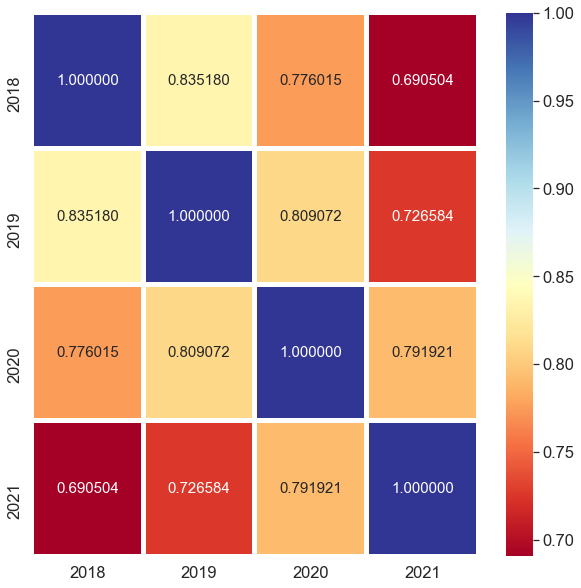

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5) # label 글자 크기 조절
htmap = sns.heatmap(cos_df,annot=True,fmt='f', linewidths=4, cmap='RdYlBu',annot_kws={"size": 15}) #YlGnBu, RdYlBu, PiYG, YlOrRd

## WordCloud

In [ ]:
# 코로나 이전과 이후로 나눠서 워드클라우드 생성
beforec_word_cleaned = []
afterc_word_cleaned = []
beforec_word_cleaned = word_cleaned_18 + word_cleaned_19
afterc_word_cleaned = word_cleaned_20 + word_cleaned_21

In [ ]:
print(len(beforec_word_cleaned))
print(len((afterc_word_cleaned)))

43266
30083


In [ ]:
# 단어 출현횟수 카운트
beforec_word_cnt = Counter(beforec_word_cleaned)
afterc_word_cnt = Counter(afterc_word_cleaned)

beforec_word_dic = dict(beforec_word_cnt) 
afterc_word_dic = dict(afterc_word_cnt)

In [ ]:
# 단어 출현횟수를 기준으로 내림차순 정렬
sorted_beforec = sorted(beforec_word_dic.items(),key=lambda x:x[1],reverse=True)
sorted_afterc = sorted(afterc_word_dic.items(),key=lambda x:x[1],reverse=True)

# 출현횟수 상위 50개의 단어까지만 슬라이싱
top_sorted_beforec = dict(sorted_beforec[:50])
top_sorted_afterc = dict(sorted_afterc[:50])

In [ ]:
# apple로고 워드클라우드를 만드는 사용자 함수
def appleWordCloud(word_dic, filename):
    apple_logo = np.array(Image.open('apple1.jpg'))
    image_colors = ImageColorGenerator(apple_logo)

    word_cloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf",
                           width = 2000, height = 1000,
                           mask = apple_logo,
                           background_color = 'white').generate_from_frequencies(word_dic)

    word_cloud = word_cloud.recolor(color_func=image_colors)
    word_cloud.to_file(filename='{}.jpg'.format(filename))
    plt.figure(figsize=(15,15))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

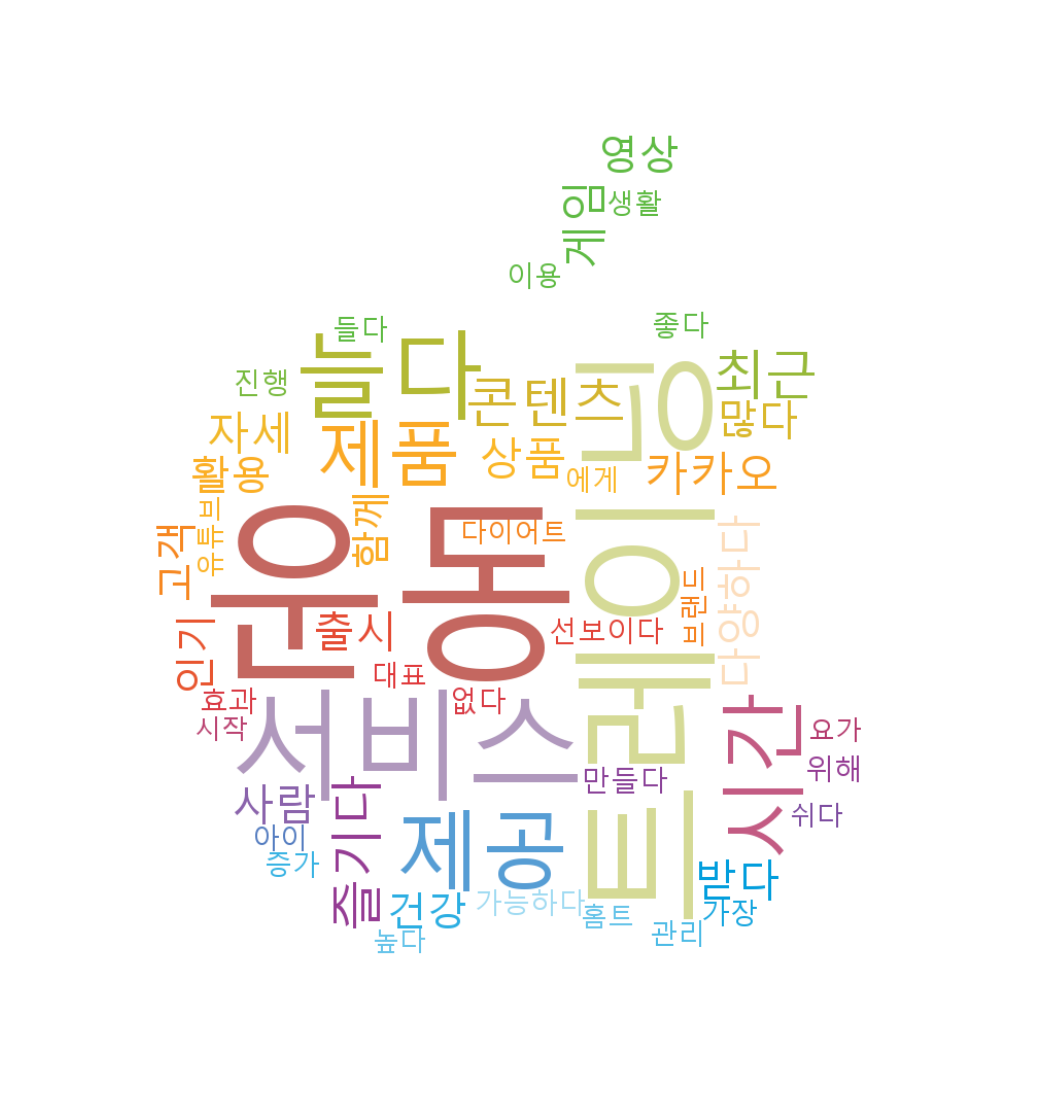

In [ ]:
appleWordCloud(top_sorted_beforec,'beforec_apple')

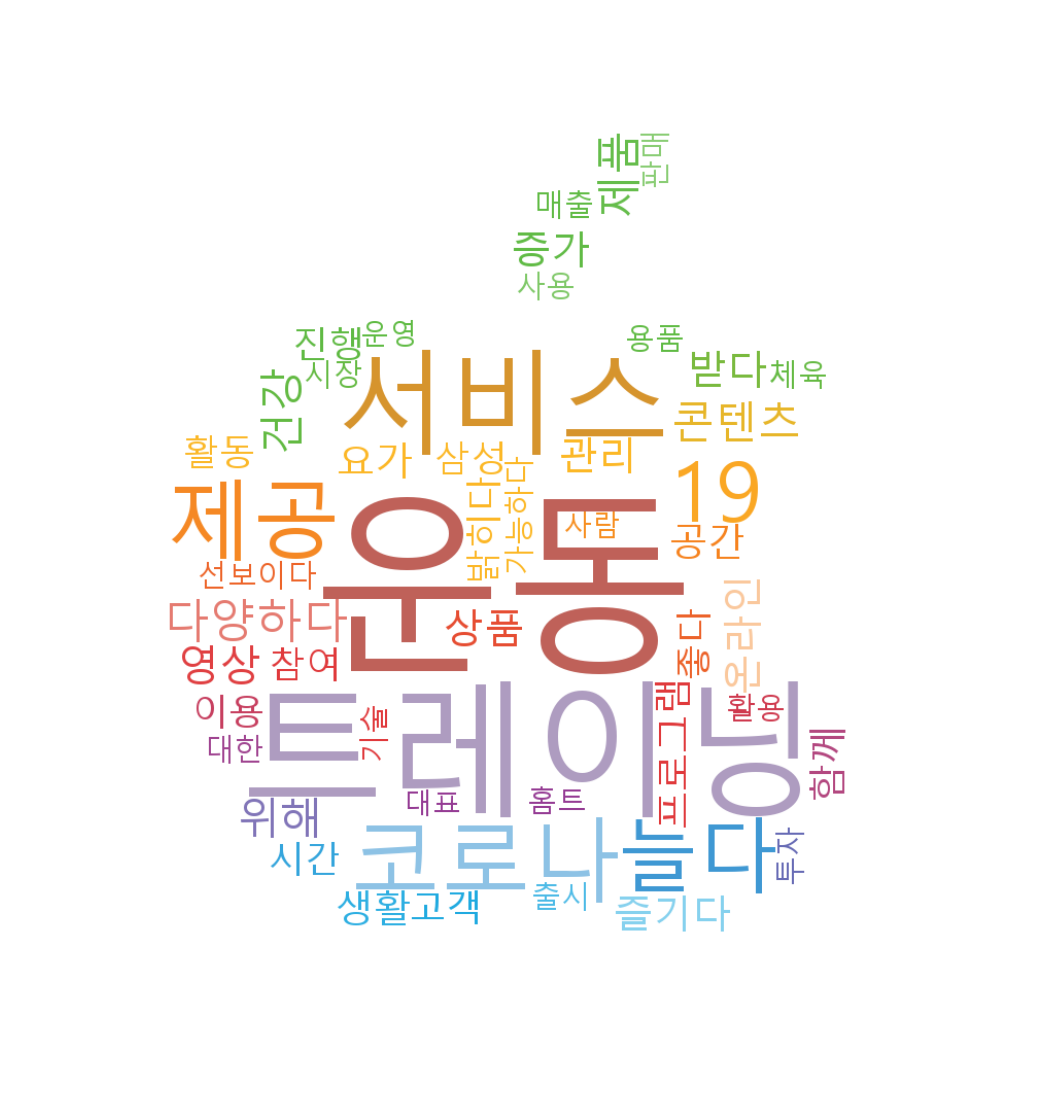

In [ ]:
appleWordCloud(top_sorted_afterc,'afterc_apple')